In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import copy

from sklearn import datasets
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

import matplotlib.pyplot as plt

from tqdm.notebook import tqdm

color_list = [x["color"] for x in plt.rcParams["axes.prop_cycle"]]

from matplotlib.ticker import MaxNLocator

import multiprocessing
import os

In [3]:
from lut import *

## Custom dataset

In [ ]:
from sklearn.datasets import make_moons

In [ ]:
X_float, y_float = make_moons(n_samples=1000, shuffle=True, noise=0.05, random_state=None)

In [ ]:
scaler = MinMaxScaler(feature_range=(0, 1))
X_tf = scaler.fit_transform(X_float)
X = X_tf > 0.5

y = y_float.astype(bool)

In [ ]:
lut = Lut(2, [100, 100, 100, 100])
preds_train = lut.train(X, y)

print(f"Accuracy on training set: {accuracy_score(preds_train, y):.2f}%")

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(8, 4))

ax = axs[0]
ax.scatter(X_tf[:, 0], X_tf[:, 1], c=y_float, cmap="bwr");

ax = axs[1]
ax.scatter(X_tf[:, 0], X_tf[:, 1], c=preds_train, cmap="bwr")

plt.tight_layout();

## MNIST

In [5]:
data = np.load("data/lut/MNIST.npz", allow_pickle=True)
X_ = data["X"]
y_ = data["y"]

scaler = MinMaxScaler(feature_range=(0, 1))
X_tf = scaler.fit_transform(X_)

X = (X_tf > 0.5).astype(bool)
y = (y_ == 0) | (y_ == 1) | (y_ == 2) | (y_ == 3) | (y_ == 4)

X, y = shuffle(X, y, n_samples=10_000, random_state=100)

X_train, X_test, y_train, y_test, = train_test_split(
    X, y, test_size=0.33, random_state=42, shuffle=False
)

In [7]:
%%time
lut = Lut(6, [100, 100, 100])
preds_train = lut.train(X_train, y_train)
preds_test = lut.predict(X_test)

print(f"Accuracy on training set: {accuracy_score(preds_train, y_train):.2f}%")
print(f"Accuracy on test set: {accuracy_score(preds_test, y_test):.2f}%")

Accuracy on training set: 0.83%
Accuracy on test set: 0.81%
CPU times: user 403 ms, sys: 273 ms, total: 675 ms
Wall time: 1.2 s


# MNIST PCA

In [36]:
from lut_old import *
import pickle

In [49]:
data = np.load("data/lut/MNIST.npz", allow_pickle=True)
X_ = data["X"]
y_ = data["y"]
# y_bool = (y_ == 0) | (y_ == 1) | (y_ == 2) | (y_ == 3) | (y_ == 4)
y_bool = np.random.choice([True, False], size=X_.shape[0])

train_acc = []
test_acc = []
rnd = []
range_k = range(2, 21)
for k in tqdm(range_k):
    pca = PCA(n_components=k)
    X_pca = pca.fit_transform(X_)
    scaler = MinMaxScaler(feature_range=(0, 1))
    X_tf = scaler.fit_transform(X_pca)
    X = (X_tf > 0.5).astype(bool)
    X, y = shuffle(X, y_bool, n_samples=10_000, random_state=100)
    X_train, X_test, y_train, y_test, = train_test_split(
        X, y, test_size=0.33, random_state=42, shuffle=False
    )
    lut = Lut(k)
    lut.train(np.hstack((X_train, y_train[:, None])))
    preds_train = lut.predict(np.hstack((X_train, y_train[:, None])))
    preds_test = lut.predict(np.hstack((X_test, y_test[:, None])))

    train_acc.append(accuracy_score(preds_train, y_train))
    test_acc.append(accuracy_score(preds_test, y_test))
    rnd.append(lut.rnd.sum() / len(lut.rnd.ravel()))

with open(r"data/lut/single_lut_random.pkl", "wb") as f:
    pickle.dump(
        [
            train_acc,
            test_acc,
            rnd,
            range_k,
            "contents: train_acc, test_acc, rnd, range_k, labels random",
        ],
        f,
    )

  0%|          | 0/19 [00:00<?, ?it/s]

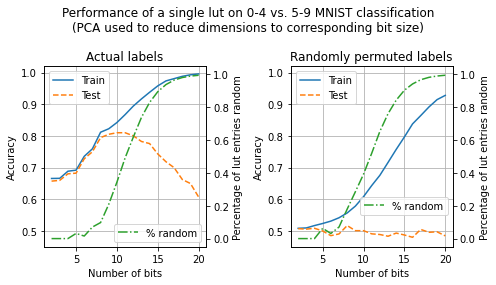

In [73]:
color_list = [x["color"] for x in plt.rcParams["axes.prop_cycle"]]

fig, axs = plt.subplots(1, 2, figsize=(7, 4))

with open(r"data/lut/single_lut_not_random.pkl", "rb") as f:
    tmp = pickle.load(f)
train_acc = tmp[0]
test_acc = tmp[1]
rnd = tmp[2]
range_k = tmp[3]

ax = axs[0]
ax.plot(range_k, train_acc, label="Train")
ax.plot(range_k, test_acc, label="Test", ls="--")
ax.legend()
ax.grid()
ax.set_title("Actual labels")
ax.set_xlabel("Number of bits")
ax.set_ylabel("Accuracy")
ax.set_ylim(0.45, 1.02)

ax2 = ax.twinx()
ax2.plot(range_k, rnd, label="% random", c=color_list[2], ls="-.")
ax2.legend(loc="lower right")
ax2.set_ylabel("Percentage of lut entries random")
ax2.set_ylim(-0.05, 1.05)

with open(r"data/lut/single_lut_random.pkl", "rb") as f:
    tmp = pickle.load(f)
train_acc = tmp[0]
test_acc = tmp[1]
rnd = tmp[2]
range_k = tmp[3]

ax = axs[1]
ax.plot(range_k, train_acc, label="Train")
ax.plot(range_k, test_acc, label="Test", ls="--")
ax.legend()
ax.set_title("Randomly permuted labels")
ax.set_xlabel("Number of bits")
ax.set_ylabel("Accuracy")
ax.set_ylim(0.45, 1.02)
ax.grid()

ax2 = ax.twinx()
ax2.set_ylabel("Percentage of lut entries random")
ax2.plot(range_k, rnd, label="% random", c=color_list[2], ls="-.")
ax2.legend(loc="lower right", bbox_to_anchor=(1, .15))
ax2.set_ylim(-0.05, 1.05)

plt.suptitle("Performance of a single lut on 0-4 vs. 5-9 MNIST classification\n(PCA used to reduce dimensions to corresponding bit size)")

plt.tight_layout();

In [74]:
fig.savefig(r"seminar/images/single_lut_exp.pdf", bbox_inches="tight")

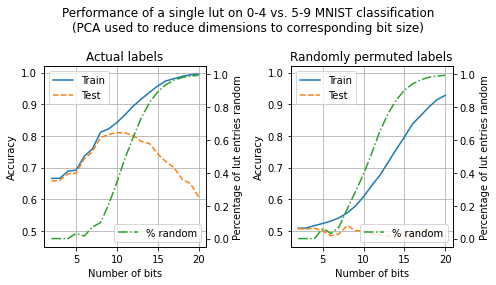

In [56]:
import numpy as np
import copy

def count_recursive(cnt, x):
    """
    Given an array that stores counts of shape ([2] * (bits + 1)) (the last two dimensions
    for y0 and y1, respectively), increase the count by 1 for given pattern (all but last
    entries of x) and whether it's y0 or y1 (the last entry of x). This function is recursive.

    Parameters
    ==========
    cnt: np.ndarray
        Array that stores counts for a given dataset.
    x: list
        Single training example as list. The last entry is for y.
    """
    if len(x) > 1:
        idx = x.pop(0)
        count_recursive(cnt[int(idx)], x)
    else:
        cnt[int(x[0])] += 1


class Lut:
    def __init__(self, bits):
        self.bits = bits
        self.lut = None
        self.rnd = None
        self.cnt = None
        self.cols = None

    def train(self, training_set, cols=None):
        """
        Train the lut given a training set.

        Parameters
        ==========
        training_set: numpy.ndarray
            Numpy array of shape (N, self.bits + 1) and dtype bool. The last column is for y.
        cols: list, optional
            List of indices to select columns. The lut will then be trained on a training set
            with less columns.
        """
        assert self.lut is None, "Lut is already trained!"
        if cols is not None:
            assert len(cols) == self.bits, f"Number of selected columns has to match bit size"
            self.cols = cols
            cols_ = copy.deepcopy(cols)
            cols_.append(-1)
            training_set_ = training_set[:, cols_]
        else:
            self.cols = list(range(training_set.shape[1] - 1))
            training_set_ = training_set

        cnt = np.zeros([2] * (self.bits + 1), dtype=np.uint32)
        for x in training_set_:
            count_recursive(cnt, list(x))

        cnt_ = cnt.reshape((-1, 2))

        lut = np.zeros(([2] * (training_set_.shape[1] - 1)), dtype=bool)
        rnd = np.zeros_like(lut)

        for i in range(2 ** self.bits):
            if cnt_[i, 0] > cnt_[i, 1]:
                lut.ravel()[i] = 0
                rnd.ravel()[i] = 0
            elif cnt_[i, 0] < cnt_[i, 1]:
                lut.ravel()[i] = 1
                rnd.ravel()[i] = 0
            else:
                lut.ravel()[i] = np.random.choice([0, 1])
                rnd.ravel()[i] = 1

        self.lut = lut
        self.cnt = cnt
        self.rnd = rnd

    def predict(self, data_set):
        assert self.lut is not None, f"Lut not trained yet!"
        preds = np.zeros((data_set.shape[0],), dtype=bool)
        for idx, x in enumerate(data_set):
            cols = copy.deepcopy(self.cols)
            preds[idx] = classify_single_training_example(self, cols, x)
        return preds

    def __repr__(self):
        if self.lut is not None:
            return f"Trained lut, {self.bits} bits"
        else:
            return f"Empty lut, {self.bits} bits"

    def get_lut_table(self):
        if self.lut is not None:
            string = ""
            for i in range(2 ** self.bits):
                bit_string = "0" * (self.bits - len(f"{i:b}")) + f"{i:b}"
                is_rnd = "*" if self.rnd.ravel()[i] else ""
                string += bit_string + "  " + f"{self.lut.ravel()[i]:d}" + is_rnd + "\n"
            return string
        else:
            return f"Lut not trained yet, no table to return"

    def __getitem__(self, idx):
        return self.lut[idx]

    def get_cnt_table(self):
        """
        Returns a string of the count table for the lut.
        """
        assert self.cnt is not None, "Lut not trained yet, no counts to return"
        cnt_ = self.cnt.reshape((-1, 2))
        string = ""
        for i in range(2 ** self.bits):
            bit_string = "0" * (self.bits - len(f"{i:b}")) + f"{i:b}"
            string += bit_string + "  " + f"{cnt_[i, 0]} " + f"{cnt_[i, 1]}" + "\n"
        return string


def classify_single_training_example(lut, cols, training_example):
    """
    Given a single training example and list of column indices that the lut operates on,
    classify that bit pattern.

    Parameters
    lut: Lut
        Lookup table object.
    cols: list
        List of columns that the lut operates on.
    training_example: list
        Single row from a training set.
    """
    if len(cols) > 1:
        idx = cols.pop(0)
        return classify_single_training_example(lut[int(training_example[idx])], cols, training_example)
    else:
        return lut[int(training_example[cols[0]])]


def training_set_from_luts(luts, orig_training_set):
    """
    Given a list of luts trained on a subset of the original dataset, obtain a new training set
    where the y labels are the same and the features come according to what the luts classify.

    Parameters
    ==========
    luts: array-like
        List of luts.
    orig_training_set: np.ndarray
        Original training_set where the luts were trained on.
    """
    training_set = np.zeros((orig_training_set.shape[0], len(luts) + 1), dtype=bool)
    training_set[:, -1] = orig_training_set[:, -1]
    for i in range(len(orig_training_set)):
        for j in range(len(luts)):
            cols = copy.deepcopy(luts[j].cols)
            x = list(orig_training_set[i])
            training_set[i, j] = classify_single_training_example(luts[j], cols, x)

    return training_set


def get_lut_performance(lut, X_train, X_test):
    preds = lut.predict(X_train)
    print(f"Accuracy on training set: {accuracy_score(preds, X_train[:, -1]):.2f}%")
    preds = lut.predict(X_test)
    print(f"Accuracy on test set: {accuracy_score(preds, X_test[:, -1]):.2f}%")
    print(f"{lut.rnd.sum() / len(lut.rnd.ravel()) * 100:.2f}% of lut entries are random")

## Percentage random

In [ ]:
rnd_arr = []
for i in range(2, 11):
    lut = Lut(6, [100] * i)
    preds_train = lut.train(X_train, y_train)
    rnd_arr.append([x.sum() / len(x.ravel()) for x in lut.rnd_arr_])

In [ ]:
fig, ax = plt.subplots(1, 1)
for i, rnd in enumerate(rnd_arr):
    ax.plot(range(2, len(rnd) + 2), rnd, label=i + 2)
    
ax.grid()
ax.set_xticks(range(2, 13))
ax.set_xticklabels(range(2, 13))
ax.set_xlabel("Hidden layer")
ax.set_ylabel("Percentage of lut entries random")
ax.legend(bbox_to_anchor=(1, 1), loc="upper left", title="Number of\nhidden layers\nof respective\nlut network")
ax.set_title("Percentage of random entries for different architectures\nEach hidden layer has 100 luts");
# ax.xaxis.set_major_locator(MaxNLocator(integer=True));